In [1]:
%reload_ext autoreload

%autoreload 2
import video_processing as vp
import librain as lb
import fnames
import numpy as np
from roipoly import RoiPoly 
import matplotlib.pyplot as plt
import os
from os.path import join, getsize, isfile, isdir
import warnings
import imreg_dft as ird
from pathlib import Path
from shapely.geometry import Point, Polygon
from scipy.stats import pearsonr, ttest_ind
import cv2
from ssGMM import ss_GaussianMixtureModels
from itertools import product
import pandas as pd
import copy
import time
import math
import cv2
import glob
warnings.filterwarnings('ignore')


## Constants

In [2]:
WIDTH = 256 # GCaMP imaging width
HEIGHT = 256 # GCaMP imaging height
TRUE_FRAMERATE = 30 # Raspberry Pi Camera framerate per second
BEHAVIOUR_FRAMERATE = 300 # High Speed Camera framerate per second
TIME_WINDOW = 900 # Number of frames as window to compute the trend of correlations between difference mice

## File paths

In [3]:
path = 'C:/Users/Haozong/OneDrive/Dual Brain/Data/20230514/' # path to the pre-processed data, in which the frames before LED turns on have been removed

l_mouse = path + '2023_5_14_16_L_919106.raw' # left mouse raw braing imaging data

m_mouse = path + '2023_5_14_16_M_918051.raw' # middle (stationary) mouse raw braing imaging data

r_mouse = path + '2023_5_14_16_R_918003.raw' # right mouse raw braing imaging data

## Extract the color channels from the RAW files

In [4]:
# left
l_mouse_green_frames = vp.extract_RAW_frames(
    filename=l_mouse,
    channel='green',
    width=WIDTH,
    height=HEIGHT
)



# middle
m_mouse_green_frames = vp.extract_RAW_frames(
    filename=m_mouse,
    channel='green',
    width=WIDTH,
    height=HEIGHT
)



# right
r_mouse_green_frames = vp.extract_RAW_frames(
    filename=r_mouse,
    channel='green',
    width=WIDTH,
    height=HEIGHT
)


# left
l_mouse_blue_frames = vp.extract_RAW_frames(
    filename=l_mouse,
    channel='blue',
    width=WIDTH,
    height=HEIGHT
)

# middle
m_mouse_blue_frames = vp.extract_RAW_frames(
    filename=m_mouse,
    channel='blue',
    width=WIDTH,
    height=HEIGHT
)

# right
r_mouse_blue_frames = vp.extract_RAW_frames(
    filename=r_mouse,
    channel='blue',
    width=WIDTH,
    height=HEIGHT
)

(880607232,)
4479.0
(880607232,)
4479.0
(880607232,)
4479.0
(880607232,)
4479.0
(880607232,)
4479.0
(880607232,)
4479.0


###  Calculate $\frac{\Delta F}{F _{0}}$
#### Where:
####     $F_{0}$ = $\frac{1}{n}\sum_{i=1}^{n} F_{i}$
####     $\Delta F$ = $F - F_{0}$

In [5]:
l_mouse_green_frames, l_mouse_green_variance = vp.calculate_df_f0(l_mouse_green_frames)
l_mouse_blue_frames, l_mouse_blue_variance = vp.calculate_df_f0(l_mouse_blue_frames)

m_mouse_green_frames, m_mouse_green_variance = vp.calculate_df_f0(m_mouse_green_frames)
m_mouse_blue_frames, m_mouse_blue_variance = vp.calculate_df_f0(m_mouse_blue_frames)

r_mouse_green_frames, r_mouse_green_variance = vp.calculate_df_f0(r_mouse_green_frames)
r_mouse_blue_frames, r_mouse_blue_variance = vp.calculate_df_f0(r_mouse_blue_frames)

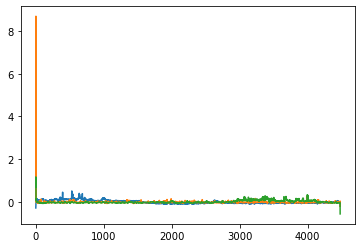

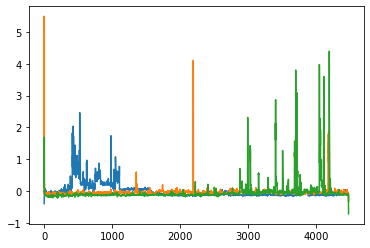

In [6]:
plt.figure()
plt.plot(np.nanmean(np.nanmean(l_mouse_green_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(m_mouse_green_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(r_mouse_green_frames, axis=2), axis=1))


plt.figure()
plt.plot(np.nanmean(np.nanmean(l_mouse_blue_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(m_mouse_blue_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(r_mouse_blue_frames, axis=2), axis=1))

## Apply lfilter using chebychev type 1 filter parameters 

In [7]:
# initialise the filtering paramters by creating a Filter object
low_limit = 0.01
high_limit = 12.0

filt = vp.Filter(
    low_freq_cutoff=low_limit,
    high_freq_cutoff=high_limit,
    frame_rate=TRUE_FRAMERATE
)

# apply the filters
l_mouse_green_frames = filt.filter(l_mouse_green_frames)
m_mouse_green_frames = filt.filter(m_mouse_green_frames)
r_mouse_green_frames = filt.filter(r_mouse_green_frames)
l_mouse_blue_frames = filt.filter(l_mouse_blue_frames)
m_mouse_blue_frames = filt.filter(m_mouse_blue_frames)
r_mouse_blue_frames = filt.filter(r_mouse_blue_frames)

## Ensure the frames have the same dimensions

In [8]:
if l_mouse_green_frames.shape[0] != r_mouse_green_frames.shape[0]:
    if l_mouse_green_frames.shape[0] < r_mouse_green_frames.shape[0]:
        r_mouse_green_frames = r_mouse_green_frames[:l_mouse_green_frames.shape[0]]
        r_mouse_blue_frames = r_mouse_blue_frames[:l_mouse_blue_frames.shape[0]]
#         r_mouse_red_frames = r_mouse_red_frames[:l_mouse_red_frames_frames.shape[0]]
    elif r_mouse_green_frames.shape[0] < l_mouse_green_frames.shape[0]:
        l_mouse_green_frames = l_mouse_green_frames[:r_mouse_green_frames.shape[0]]
        l_mouse_blue_frames = l_mouse_blue_frames[:r_mouse_blue_frames.shape[0]]
#         l_mouse_red_frames = l_mouse_red_frames[:r_mouse_red_frames.shape[0]]

assert l_mouse_green_frames.shape[0] == r_mouse_green_frames.shape[0]

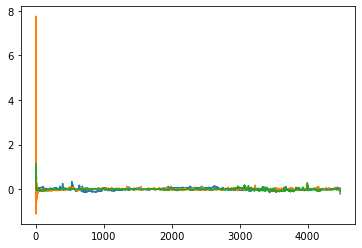

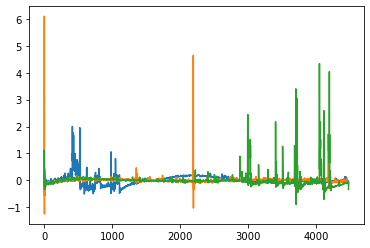

In [9]:
plt.figure()
plt.plot(np.nanmean(np.nanmean(l_mouse_green_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(m_mouse_green_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(r_mouse_green_frames, axis=2), axis=1))


plt.figure()
plt.plot(np.nanmean(np.nanmean(l_mouse_blue_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(m_mouse_blue_frames, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(r_mouse_blue_frames, axis=2), axis=1))

## Save processed frames 

In [10]:
def savevideo(data, filename, fps=TRUE_FRAMERATE):
    # normalize data
    global_min = -10
    global_max = 10
    data = np.clip(data, -10, 10)
    norm_data = 255 * (data - global_min) / (global_max - global_min)
    norm_data = norm_data.astype(np.uint8)
    out = cv2.VideoWriter(filename+'.avi', cv2.VideoWriter_fourcc('I','4','2','0'), fps, (256, 256), False)
    for i in range(norm_data.shape[0]):
        frame = norm_data[i,:,:]
        out.write(frame)
    out.release()

## Perform signal correction $\frac{A}{B+1}$

### Where:
### A = $\frac{\Delta F}{F _{0}}$ from fluorescence
### B = $\frac{\Delta F}{F _{0}}$ from reflectance

In [11]:
# Note: sometimes the short blue LED is overheating or broken and the signal correction might return strange results!

l_mouse_green_by_blue = vp.correct_channel_a_by_b(l_mouse_green_frames, l_mouse_blue_frames)

m_mouse_green_by_blue = vp.correct_channel_a_by_b(m_mouse_green_frames, m_mouse_blue_frames)

r_mouse_green_by_blue = vp.correct_channel_a_by_b(r_mouse_green_frames, r_mouse_blue_frames)

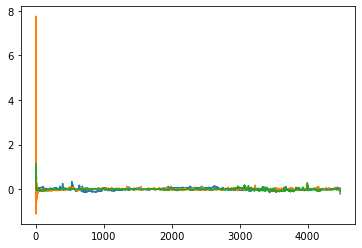

In [12]:
plt.figure()
plt.plot(np.nanmean(np.nanmean(l_mouse_green_by_blue, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(m_mouse_green_by_blue, axis=2), axis=1))
plt.plot(np.nanmean(np.nanmean(r_mouse_green_by_blue, axis=2), axis=1))

## Save corrected frames

In [13]:
#savevideo(data=l_mouse_green_frames, filename='l_green_by_blue')

In [14]:
#savevideo(data=m_mouse_green_by_blue, filename='m_green_by_blue')

In [15]:
#savevideo(data=r_mouse_green_by_blue, filename='r_green_by_blue')

## Semi-Supervised GMM

This is just a rough semi-supervised brain region clustering method. For better and more sophisticated brain region clustering method, go to https://github.com/bf777/MesoNet refering the paper "MesoNet allows automated scaling and segmentation of mouse mesoscale cortical maps using machine learning" (Xiao et al, 2021).

In [16]:
def RegionCluster(tensor, Xcenters_left, X_centers_right, ycenters_left, ycenters_right, region_of_interest_left, \
                    region_of_interest_right, corr_weight=10, d=1):
    
    
    def HemisphereCluster(tensor, Xcenters, ycenters, region_of_interest, corr_weight, d):

        '''
        tensor: numpy array generated from brain imaging video, (frames, height, width)
        Xcenters: coordinates of the human selected centers
        ycenters: labels of the human selected centers
        region_of_interest: Polygon(coordinates) generated from shapely.geometry and human effect
        corr_weight: a scaling constant deciding the weight of correlations relative to spacial distances in clustering
        d: extension of pixels from the centers chosen as labeled data
        '''

        # Construct a dataframe containing feature vectors that represent pixels. 
        # Columns are X coordinates, Y coordinates, aand the correlations with the labeled brain region centers.  
        Xcenters = Xcenters
        ycenters = ycenters
        columns = ['x_coord', 'y_coord']
        for label in ycenters:
            columns.append(label+'_corr')
        ynumbers = [i+3 for i in range(len(ycenters)-1)]
        ynumbers.append(1)
        df_label_number = pd.DataFrame({'ycenters': ycenters, 'ynumbers': ynumbers})
        x_coord = []
        y_coord = []
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[2]):
                if Point(i, j).within(region_of_interest):
                    x_coord.append(i)
                    y_coord.append(j)
        df_pixel = pd.DataFrame({'x_coord': x_coord, 'y_coord': y_coord})

        for coord, label in zip(Xcenters, ycenters):
            df_pixel[label+'_corr'] = np.zeros(len(df_pixel))
            for i in range(len(df_pixel)):
                df_pixel.loc[i, label+'_corr'] = corr_weight * np.corrcoef(tensor[:,df_pixel.loc[i, 'x_coord'],df_pixel.loc[i, 'y_coord']], \
                                                                           tensor[:,coord[0],coord[1]])[0,1]


        # Generate Xtrain and ytrain data for the supervised part of GMM clustering
        # Xtrain data contains the centers and their surrounding pixels, ytrain data is their labels (converted to numbers)
        # Xtest data contains the rest unlabeled pixels
        X_train = None
        y_train = None
        for coord, number in zip(Xcenters, ynumbers):
            if number == 1:
                d = d + 2
                L = len(df_pixel[(df_pixel['x_coord']<=coord[0]+d)&(df_pixel['x_coord']>=coord[0]-d)& \
                    (df_pixel['y_coord']<=coord[1]+d)&(df_pixel['y_coord']>=coord[1]-d)])
                if (X_train is None):
                    X_train = np.array(df_pixel[(df_pixel['x_coord']<=coord[0]+d)&(df_pixel['x_coord']>=coord[0]-d)& \
                                        (df_pixel['y_coord']<=coord[1]+d)&(df_pixel['y_coord']>=coord[1]-d)])
                else:
                    X_train = np.vstack((X_train, np.array(df_pixel[(df_pixel['x_coord']<=coord[0]+d)&(df_pixel['x_coord']>=coord[0]-d)& \
                                        (df_pixel['y_coord']<=coord[1]+d)&(df_pixel['y_coord']>=coord[1]-d)])))
                if (y_train is None):
                    y_train = np.full((L, 1), number)
                else:
                    
                    y_train = np.vstack((y_train, np.full((L, 1), number)))
                d = d - 2
            else:
                L = len(df_pixel[(df_pixel['x_coord']<=coord[0]+d)&(df_pixel['x_coord']>=coord[0]-d)& \
                    (df_pixel['y_coord']<=coord[1]+d)&(df_pixel['y_coord']>=coord[1]-d)])
                if (X_train is None):
                    X_train = np.array(df_pixel[(df_pixel['x_coord']<=coord[0]+d)&(df_pixel['x_coord']>=coord[0]-d)& \
                                        (df_pixel['y_coord']<=coord[1]+d)&(df_pixel['y_coord']>=coord[1]-d)])
                else:
                    X_train = np.vstack((X_train, np.array(df_pixel[(df_pixel['x_coord']<=coord[0]+d)&(df_pixel['x_coord']>=coord[0]-d)& \
                                        (df_pixel['y_coord']<=coord[1]+d)&(df_pixel['y_coord']>=coord[1]-d)])))
                if (y_train is None):
                    y_train = np.full((L, 1), number)
                else:
                    y_train = np.vstack((y_train, np.full((L, 1), number)))
        X_train = pd.DataFrame(X_train, columns=columns)
        X_test = df_pixel.drop(X_train.index)
        # Convert dataframe into numpy array
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        
        
        ss_GMMresults = ss_GaussianMixtureModels(X_train, y_train, X_test, beta=0.50, tol=0.1, max_iterations=20, early_stop='True')


        # Assign labels to the unlabeled data and turn the whole dataset back to dataframe
        data_train = np.hstack((X_train, y_train))
        data_test = np.hstack((X_test, np.reshape(ss_GMMresults[0], (X_test.shape[0], 1))))
        data = np.vstack((data_train, data_test))
        columns.append('label')
        df_data = pd.DataFrame(data, columns=columns)


        # Put the results back into a graph matrix, with pixels belonging to same region have the same number
        # Pixels outside region of interest will be set to 0 (dark)
        graph_matrix = np.zeros((tensor.shape[1],tensor.shape[2]))
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[2]):
                if ((df_data['x_coord']==i) & (df_data['y_coord']==j)).any():
                    try:
                        graph_matrix[i,j] = np.mean(df_data[(df_data['x_coord']==i)&(df_data['y_coord']==j)]['label'])
                    except:
                        print(df_data[(df_data['x_coord']==i)&(df_data['y_coord']==j)]['label'])

        # Plot the results
        #df_label_number
        #plt.matshow(graph_matrix)
        #plt.show()
        '''
        ssgmm: center + surroundings
        note: clustering - high dimension, pca or not?
        peripheral? -- choose the middle
        left and right difference
        loop - convergency?
        try tsne - it might work? tune ssgmm based on tsne
        make left and right same color, color setting
        '''
        return graph_matrix, df_data
    
    graph_matrix_left, df_data_left = HemisphereCluster(tensor, Xcenters_left, ycenters_left, region_of_interest_left, corr_weight, d)
    graph_matrix_right, df_data_right = HemisphereCluster(tensor, Xcenters_right, ycenters_right, region_of_interest_right, corr_weight, d)
    graph_matrix = np.zeros((tensor.shape[1],tensor.shape[2]))
    for i in range(tensor.shape[1]):
        for j in range(tensor.shape[2]):
            if graph_matrix_left[i,j] == graph_matrix_right[i,j]:
                graph_matrix[i,j] = graph_matrix_left[i,j]
                df_data_right = df_data_right.drop(df_data_right[(df_data_right.x_coord == i) & (df_data_right.y_coord == j)].index)
            elif graph_matrix_left[i,j] == 0 and graph_matrix_right[i,j] != 0:
                graph_matrix[i,j] = graph_matrix_right[i,j]
                df_data_left = df_data_left.drop(df_data_left[(df_data_left.x_coord == i) & (df_data_left.y_coord == j)].index)
            elif graph_matrix_left[i,j] != 0 and graph_matrix_right[i,j] == 0:
                graph_matrix[i,j] = graph_matrix_left[i,j]
                df_data_right = df_data_right.drop(df_data_right[(df_data_right.x_coord == i) & (df_data_right.y_coord == j)].index)
            else:
                graph_matrix[i,j] = graph_matrix_left[i,j]
                df_data_right = df_data_right.drop(df_data_right[(df_data_right.x_coord == i) & (df_data_right.y_coord == j)].index)
    del graph_matrix_left, graph_matrix_right
    
    
    df_data_left = df_data_left[['x_coord', 'y_coord', 'label']]
    df_data_left['side'] = 'left'
    df_data_right = df_data_right[['x_coord', 'y_coord', 'label']]
    df_data_right['side'] = 'right'
    df_data = pd.concat([df_data_left, df_data_right], axis=0, join='outer')
    df_data.reset_index(drop=True, inplace=True)
    
    
    return graph_matrix, df_data

## Run the SSGMM on the data

Number of labeled data: 111
Number of unlabeled data: 25827
Number of labeled data: 111
Number of unlabeled data: 27733


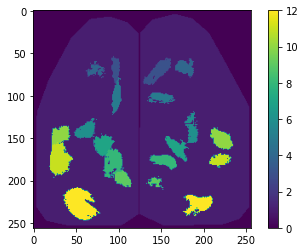

In [17]:
# Set up the ROI polygon
# For now just use Image-J macro to find the points


coords_left = [(124,239),(104,252),(73,253),(38,252),(15,247),(3,230),(2,125),(18,81),(45,31),(67,10),(90,7),(111,14),(124,28)]
region_of_interest_left = Polygon(coords_left)
coords_right = [(124,28),(139,11),(166,4),(186,9),(206,26),(225,60),(254,114),(254,230),(242,245),(223,251),(154,253),(124,239)]
region_of_interest_right = Polygon(coords_right)

# Select Centers
Xcenters_left = [[96,67],[72,69],[99,101],[60,142],[82,157],[93,176],[106,200],[27,148],[27,175],[59,227], \
           [124,144]]
ycenters_left = ['M2','ALM','wM1','FL','HL','PtA','RS','aBC','pBC','V1', \
           'Base']
Xcenters_right = []
for i in range(len(Xcenters_left)-1):
    center = Xcenters_left[-1]
    coord = copy.deepcopy(Xcenters_left[i])
    coord[0] = center[0]*2 - coord[0]
    Xcenters_right.append(coord)
Xcenters_right.append(Xcenters_left[-1])
ycenters_right = ['M2','ALM','wM1','FL','HL','PtA','RS','aBC','pBC','V1', \
           'Base']


graph_matrix_L, df_data_L = RegionCluster(l_mouse_green_by_blue, Xcenters_left, Xcenters_right, ycenters_left, ycenters_right, \
                                      region_of_interest_left, region_of_interest_right, corr_weight=5, d=1)

plt.figure()
plt.imshow(graph_matrix_L.T)
plt.colorbar()
plt.show()

Number of labeled data: 111
Number of unlabeled data: 23265
Number of labeled data: 111
Number of unlabeled data: 26521


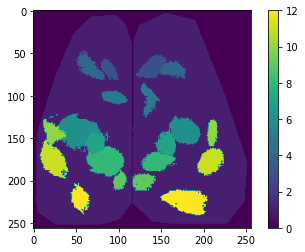

In [18]:
# Set up the ROI polygon
# For now just use Image-J macro to find the points


coords_left = [(116,226),(100,246),(77,252),(25,251),(5,237),(0,198),(5,141),(26,76),(47,27),(68,7),(98,5),(108,15),(116,39)]
region_of_interest_left = Polygon(coords_left)
coords_right = [(116,39),(124,17),(155,3),(190,11),(224,97),(251,177),(248,224),(228,250),(168,251),(140,248),(116,226)]
region_of_interest_right = Polygon(coords_right)

# Select Centers
Xcenters_left = [[90,69],[68,70],[93,102],[55,142],[74,156],[86,176],[99,200],[22,147],[22,177],[54,225], \
           [116,139]]
ycenters_left = ['M2','ALM','wM1','FL','HL','PtA','RS','aBC','pBC','V1', \
           'Base']
Xcenters_right = []
for i in range(len(Xcenters_left)-1):
    center = Xcenters_left[-1]
    coord = copy.deepcopy(Xcenters_left[i])
    coord[0] = center[0]*2 - coord[0]
    Xcenters_right.append(coord)
Xcenters_right.append(Xcenters_left[-1])
ycenters_right = ['M2','ALM','wM1','FL','HL','PtA','RS','aBC','pBC','V1', \
           'Base']


graph_matrix_M, df_data_M = RegionCluster(m_mouse_green_by_blue, Xcenters_left, Xcenters_right, ycenters_left, ycenters_right, \
                                      region_of_interest_left, region_of_interest_right, corr_weight=5, d=1)

plt.figure()
plt.imshow(graph_matrix_M.T)
plt.colorbar()
plt.show()

Number of labeled data: 111
Number of unlabeled data: 24887
Number of labeled data: 111
Number of unlabeled data: 25520


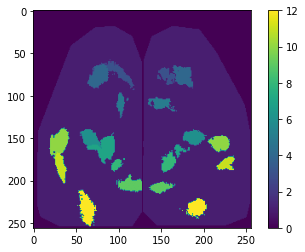

In [19]:
# Set up the ROI polygon
# For now just use Image-J macro to find the points


coords_left = [(128,236),(116,254),(29,253),(8,242),(2,220),(5,143),(44,41),(72,20),(95,18),(116,30),(128,62)]
region_of_interest_left = Polygon(coords_left)
coords_right = [(128,62),(139,30),(163,18),(195,22),(215,49),(248,110),(255,144),(255,224),(250,243),(227,252),(145,253),(128,236)]
region_of_interest_right = Polygon(coords_right)


# Select Centers
Xcenters_left = [[102,74],[79,75],[104,109],[66,148],[86,162],[98,182],[111,207],[32,155],[32,182],[64,233], \
           [128,157]]
ycenters_left = ['M2','ALM','wM1','FL','HL','PtA','RS','aBC','pBC','V1', \
           'Base']
Xcenters_right = []
for i in range(len(Xcenters_left)-1):
    center = Xcenters_left[-1]
    coord = copy.deepcopy(Xcenters_left[i])
    coord[0] = center[0]*2 - coord[0]
    Xcenters_right.append(coord)
Xcenters_right.append(Xcenters_left[-1])
ycenters_right = ['M2','ALM','wM1','FL','HL','PtA','RS','aBC','pBC','V1', \
           'Base']


graph_matrix_R, df_data_R = RegionCluster(r_mouse_green_by_blue, Xcenters_left, Xcenters_right, ycenters_left, ycenters_right, \
                                      region_of_interest_left, region_of_interest_right, corr_weight=5, d=1)

plt.figure()
plt.imshow(graph_matrix_R.T)
plt.colorbar()
plt.show()

## Interaction Window & Order

In [20]:
interaction_window = [(520,1395), (1816,2691), (3113,3988)]
interaction_order = ['Left(cagemate) & Middle', 'Rest', 'Right(novel) & Middle']

## Perform Regional Correlation Analysis

In [21]:
def RegionCorrelation(region_left, region_middle, region_right, tensor_left, tensor_middle, tensor_right, \
                      interaction_window, interaction_order, title=''):
    '''
    region_left / middle / right: a set of coordinates representing a specific region in the animal (DataFrame)
    tensor_left / middle / right: the processed brain imaging video of the animal (DataFrame)
    '''
    corr_list_ML = []
    corr_list_MR = []
    corr_list_LR = []
    for window, order in zip(interaction_window, interaction_order): 
        left_sample = []
        middle_sample = []
        right_sample = []
        for i in range(window[0], window[1]):
            left_points = []
            middle_points = []
            right_points = []
            for x_coord, y_coord in zip(region_left['x_coord'], region_left['y_coord']):
                left_points.append(tensor_left[i, int(x_coord), int(y_coord)])
            for x_coord, y_coord in zip(region_middle['x_coord'], region_middle['y_coord']):
                middle_points.append(tensor_middle[i, int(x_coord), int(y_coord)])
            for x_coord, y_coord in zip(region_right['x_coord'], region_right['y_coord']):
                right_points.append(tensor_right[i, int(x_coord), int(y_coord)])
            left_sample.append(np.mean(left_points))
            middle_sample.append(np.mean(middle_points))
            right_sample.append(np.mean(right_points))
        corr_list_ML.append(np.corrcoef(left_sample, middle_sample)[0,1])
        corr_list_MR.append(np.corrcoef(right_sample, middle_sample)[0,1])
        corr_list_LR.append(np.corrcoef(right_sample, left_sample)[0,1])
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 9)
    ax.set_title(title)
    ax.set_xlabel('Interactions')
    ax.set_ylabel('Correlations: delta F / F_0')
    fig.tight_layout()
    plt.rcParams['savefig.dpi'] = 500
    plt.rcParams['figure.dpi'] = 500
    plt.ylim(-1, 1)
    bar_width = 0.2
    x = np.arange(3)
    y1 = []
    y2 = []
    y3 = []
    tick_label = []
    i = 1
    for corr_ML, corr_MR, corr_LR, order in zip(corr_list_ML, corr_list_MR, corr_list_LR, interaction_order):
        y1.append(copy.deepcopy(corr_ML))
        y2.append(copy.deepcopy(corr_MR))
        y3.append(copy.deepcopy(corr_LR))
        tick_label.append(copy.deepcopy(order))
    plt.bar(x, y1, width=bar_width, color='red',label='Middle and Left')
    plt.bar(x+bar_width, y2, width=bar_width, color='green',label='Middle and Right')
    plt.bar(x+bar_width*2, y3, width=bar_width, color='blue',label='Left and Right')
    plt.xticks(x+bar_width, tick_label)
    plt.legend()
    plt.savefig(title + '.png', bbox_inches='tight')
    plt.show()
    df = pd.DataFrame({'Middle and Left':corr_list_ML, 'Middle and Right':corr_list_MR, 'Left and Right': corr_list_LR})
    df.to_csv(title+'.csv')
    
    return corr_list_ML, corr_list_MR, corr_list_LR

In [22]:
def RegionActivity(region_left, region_middle, region_right, tensor_left, tensor_middle, tensor_right, \
                      interaction_window, interaction_order, title=''):
    '''
    region_left / middle / right: a set of coordinates representing a specific region in the animal (DataFrame)
    tensor_left / middle / right: the processed brain imaging video of the animal (DataFrame)
    '''
    activity_series_L = []
    activity_series_M = []
    activity_series_R = []
    for i in range(tensor_middle.shape[0]):
        left_points = []
        middle_points = []
        right_points = []
        for x_coord, y_coord in zip(region_left['x_coord'], region_left['y_coord']):
            left_points.append(tensor_left[i, int(x_coord), int(y_coord)])
        for x_coord, y_coord in zip(region_middle['x_coord'], region_middle['y_coord']):
            middle_points.append(tensor_middle[i, int(x_coord), int(y_coord)])
        for x_coord, y_coord in zip(region_right['x_coord'], region_right['y_coord']):
            right_points.append(tensor_right[i, int(x_coord), int(y_coord)])
        activity_series_L.append(np.mean(left_points))
        activity_series_M.append(np.mean(middle_points))
        activity_series_R.append(np.mean(right_points))
    
    for i in range(2):
        fig, ax = plt.subplots()
        fig.set_size_inches(20, 5)
        ax.set_title(title)
        ax.set_ylabel('Corrected Signals: delta F / F_0')
        fig.tight_layout()
        plt.rcParams['savefig.dpi'] = 500
        plt.rcParams['figure.dpi'] = 500
        upper = np.max([np.max(activity_series_L), np.max(activity_series_M), np.max(activity_series_R)])*1.1
        lower = np.min([np.min(activity_series_L), np.min(activity_series_M), np.min(activity_series_R)])*1.1
        plt.xlim((2500*i, 2500*(i+1)))
        plt.ylim(lower, upper)
        plt.plot(np.arange(0,tensor_middle.shape[0],1)[2500*i:2500*(i+1)], \
                 activity_series_L[2500*i:2500*(i+1)], color='red', label='Left')
        plt.plot(np.arange(0,tensor_middle.shape[0],1)[2500*i:2500*(i+1)], \
                 activity_series_M[2500*i:2500*(i+1)], color='green', label='Middle')
        plt.plot(np.arange(0,tensor_middle.shape[0],1)[2500*i:2500*(i+1)], \
                 activity_series_R[2500*i:2500*(i+1)], color='blue', label='Right')
        plt.legend()
        upper = np.max([np.max(activity_series_L), np.max(activity_series_M), np.max(activity_series_R)])*1.1
        lower = np.min([np.min(activity_series_L), np.min(activity_series_M), np.min(activity_series_R)])*1.1
        for window, order in zip(interaction_window, interaction_order):
            x = [i for i in range(window[0], window[1])]
            y1 = [float(int(upper)+1) for i in range(window[0], window[1])]
            y2 = [float(int(lower)-1) for i in range(window[0], window[1])]
            if 'Left' in order:
                c = 'pink'
            elif order =='Rest':
                c = 'gray'
            else:
                c = 'skyblue'
            plt.fill_between(x, y1, y2, facecolor=c, edgecolor='black', alpha=0.2, label=order)
        plt.legend()
        plt.savefig(title + ' (' + str(i+1) + ').png', bbox_inches='tight')
        
        #df_L = pd.DataFrame({'activity':activity_series_L})
        #path_L = copy.deepcopy(l_mouse)
        #path_L = path_L.replace('.raw', '_'+title+'.csv')
        #df_L.to_csv(path_L)
        #df_M = pd.DataFrame({'activity':activity_series_M})
        #path_M = copy.deepcopy(m_mouse)
        #path_M = path_M.replace('.raw', '_'+title+'.csv')
        #df_M.to_csv(path_M)
        #df_R = pd.DataFrame({'activity':activity_series_R})
        #path_R = copy.deepcopy(r_mouse)
        #path_R = path_R.replace('.raw', '_'+title+'.csv')
        #df_R.to_csv(path_R)
        
    return activity_series_L, activity_series_M, activity_series_R

In [23]:
def RegionCorrelationTrend(region_left, region_middle, region_right, tensor_left, tensor_middle, tensor_right, \
                      interaction_window, interaction_order, period=TIME_WINDOW, title=''):
    '''
    region_left / middle / right: a set of coordinates representing a specific region in the animal (DataFrame)
    tensor_left / middle / right: the processed brain imaging video of the animal (DataFrame)
    '''
    corr_series_ML = []
    corr_series_MR = []
    corr_series_LR = []
    for k in range(int(period/2)):
        corr_series_ML.append(np.nan)
        corr_series_MR.append(np.nan)
        corr_series_LR.append(np.nan)
    for i in range(tensor_middle.shape[0]-period):
        left_sample = []
        middle_sample = []
        right_sample = []
        for j in range(period):
            left_points = []
            middle_points = []
            right_points = []
            for x_coord, y_coord in zip(region_left['x_coord'], region_left['y_coord']):
                left_points.append(tensor_left[i+j, int(x_coord), int(y_coord)])
            for x_coord, y_coord in zip(region_middle['x_coord'], region_middle['y_coord']):
                middle_points.append(tensor_middle[i+j, int(x_coord), int(y_coord)])
            for x_coord, y_coord in zip(region_right['x_coord'], region_right['y_coord']):
                right_points.append(tensor_right[i+j, int(x_coord), int(y_coord)])
            left_sample.append(np.mean(left_points))
            middle_sample.append(np.mean(middle_points))
            right_sample.append(np.mean(right_points))
        corr_series_ML.append(np.corrcoef(left_sample, middle_sample)[0,1])
        corr_series_MR.append(np.corrcoef(right_sample, middle_sample)[0,1])
        corr_series_LR.append(np.corrcoef(right_sample, left_sample)[0,1])
    for k in range(period - int(period/2)):
        corr_series_ML.append(np.nan)
        corr_series_MR.append(np.nan)
        corr_series_LR.append(np.nan)
    

    fig, ax = plt.subplots()
    fig.set_size_inches(40, 6)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Pearson correlation +/- ' + '{:.3}'.format(period/30) + ' sec')
    fig.tight_layout()
    plt.rcParams['savefig.dpi'] = 45
    plt.rcParams['figure.dpi'] = 45
    plt.xlim((0, tensor_middle.shape[0]))
    plt.ylim((-1, 1))
    plt.plot(np.arange(0,tensor_middle.shape[0],1), \
             corr_series_ML, color='red', label='Middle and Left')
    plt.plot(np.arange(0,tensor_middle.shape[0],1), \
             corr_series_MR, color='green', label='Middle and Right')
    #plt.plot(np.arange(0,tensor_middle.shape[0],1), \
             #corr_series_LR, color='blue', label='Left and Right')
    plt.legend()
    for window, order in zip(interaction_window, interaction_order):
        x = [i for i in range(window[0], window[1])]
        y1 = [1 for i in range(window[0], window[1])]
        y2 = [-1 for i in range(window[0], window[1])]
        if order == 'L & M':
            c = 'pink'
        elif order =='Rest':
            c = 'gray'
        else:
            c = 'skyblue'
        plt.fill_between(x, y1, y2, facecolor=c, edgecolor='black', alpha=0.2, label=order)
    plt.legend()
    plt.savefig(title + '_correlation_trend.png', bbox_inches='tight')
    
    # save a series of images with a vertical line representing time
    # check if path exists
    path = title + '_correlation_trend'
    if os.path.exists(path):
        pass
    else:
        os.makedirs(path)
    
    plot_no = 0
    for i in range(tensor_middle.shape[0]):
        line=ax.axvline(i, color='black', markeredgewidth=12, markersize=12)
        fig.savefig(path+'/' + title + '_correlation_trend_{plot_no:04d}.jpg'.format(plot_no=plot_no))
        plot_no += 1
        plt.pause(0.001)  # added
        line.remove()   # added
    
    # images to video
    img_array = []
    for filename in glob.glob('./' + path + '/*.jpg'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
        os.remove(filename)
    

    out = cv2.VideoWriter(title+'.mp4', cv2.VideoWriter_fourcc(*'MP4V'), TRUE_FRAMERATE, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    del img_array
    
    #return corr_series_ML, corr_series_MR, corr_series_LR

## V1

In [24]:
df_R_V1_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==12)]
df_M_V1_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==12)]
df_L_V1_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==12)]
df_R_V1_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==12)]
df_M_V1_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==12)]
df_L_V1_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==12)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_V1_left, df_M_V1_left, df_R_V1_left, \
               l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
               interaction_window, interaction_order, \
               title='Activities V1 left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_V1_left, df_M_V1_left, df_R_V1_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='V1 left')

In [ ]:
RegionCorrelationTrend(df_L_V1_left, df_M_V1_left, df_R_V1_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='V1 left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_V1_right, df_M_V1_right, df_R_V1_right, \
               l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
               interaction_window, interaction_order, \
               title='Activities V1 right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_V1_right, df_M_V1_right, df_R_V1_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='V1 right')

In [ ]:
RegionCorrelationTrend(df_L_V1_right, df_M_V1_right, df_R_V1_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='V1 right')

## pBC

In [33]:
df_R_pBC_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==11)]
df_M_pBC_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==11)]
df_L_pBC_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==11)]
df_R_pBC_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==11)]
df_M_pBC_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==11)]
df_L_pBC_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==11)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_pBC_left, df_M_pBC_left, df_R_pBC_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities pBC left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_pBC_left, df_M_pBC_left, df_R_pBC_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='pBC left')

In [ ]:
RegionCorrelationTrend(df_L_pBC_left, df_M_pBC_left, df_R_pBC_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='pBC left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_pBC_right, df_M_pBC_right, df_R_pBC_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities pBC right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_pBC_right, df_M_pBC_right, df_R_pBC_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='pBC right')

In [ ]:
RegionCorrelationTrend(df_L_pBC_right, df_M_pBC_right, df_R_pBC_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities pBC right')

## aBC

In [40]:
df_R_aBC_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==10)]
df_M_aBC_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==10)]
df_L_aBC_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==10)]
df_R_aBC_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==10)]
df_M_aBC_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==10)]
df_L_aBC_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==10)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_aBC_left, df_M_aBC_left, df_R_aBC_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities aBC left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_aBC_left, df_M_aBC_left, df_R_aBC_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='aBC left')

In [ ]:
RegionCorrelationTrend(df_L_aBC_left, df_M_aBC_left, df_R_aBC_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='aBC left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_aBC_right, df_M_aBC_right, df_R_aBC_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities aBC right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_aBC_right, df_M_aBC_right, df_R_aBC_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='aBC right')

In [ ]:
RegionCorrelationTrend(df_L_aBC_right, df_M_aBC_right, df_R_aBC_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='aBC right')

## RS

In [47]:
df_R_RS_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==9)]
df_M_RS_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==9)]
df_L_RS_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==9)]
df_R_RS_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==9)]
df_M_RS_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==9)]
df_L_RS_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==9)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_RS_left, df_M_RS_left, df_R_RS_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities RS left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_RS_left, df_M_RS_left, df_R_RS_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='RS left')

In [ ]:
RegionCorrelationTrend(df_L_RS_left, df_M_RS_left, df_R_RS_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='RS left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_RS_right, df_M_RS_right, df_R_RS_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities RS right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_RS_right, df_M_RS_right, df_R_RS_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='RS right')

In [ ]:
RegionCorrelationTrend(df_L_RS_right, df_M_RS_right, df_R_RS_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='RS right')

## PtA

In [54]:
df_R_PtA_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==8)]
df_M_PtA_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==8)]
df_L_PtA_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==8)]
df_R_PtA_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==8)]
df_M_PtA_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==8)]
df_L_PtA_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==8)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_PtA_left, df_M_PtA_left, df_R_PtA_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities PtA left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_PtA_left, df_M_PtA_left, df_R_PtA_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='PtA left')

In [ ]:
RegionCorrelationTrend(df_L_PtA_left, df_M_PtA_left, df_R_PtA_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='PtA left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_PtA_right, df_M_PtA_right, df_R_PtA_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities PtA right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_PtA_right, df_M_PtA_right, df_R_PtA_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='PtA right')

In [ ]:
RegionCorrelationTrend(df_L_PtA_right, df_M_PtA_right, df_R_PtA_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='PtA right')

## HL

In [61]:
df_R_HL_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==7)]
df_M_HL_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==7)]
df_L_HL_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==7)]
df_R_HL_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==7)]
df_M_HL_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==7)]
df_L_HL_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==7)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_HL_left, df_M_HL_left, df_R_HL_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities HL left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_HL_left, df_M_HL_left, df_R_HL_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='HL left')

In [ ]:
RegionCorrelationTrend(df_L_HL_left, df_M_HL_left, df_R_HL_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='HL left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_HL_right, df_M_HL_right, df_R_HL_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities HL right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_HL_right, df_M_HL_right, df_R_HL_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='HL right')

In [ ]:
RegionCorrelationTrend(df_L_HL_left, df_M_HL_left, df_R_HL_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='HL left')

## FL

In [68]:
df_R_FL_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==6)]
df_M_FL_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==6)]
df_L_FL_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==6)]
df_R_FL_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==6)]
df_M_FL_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==6)]
df_L_FL_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==6)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_FL_left, df_M_FL_left, df_R_FL_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities FL left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_FL_left, df_M_FL_left, df_R_FL_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='FL left')

In [ ]:
RegionCorrelationTrend(df_L_FL_left, df_M_FL_left, df_R_FL_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='FL left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_FL_right, df_M_FL_right, df_R_FL_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities FL right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_FL_right, df_M_FL_right, df_R_FL_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='FL right')

In [ ]:
RegionCorrelationTrend(df_L_FL_right, df_M_FL_right, df_R_FL_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='FL right')

## wM1

In [24]:
df_R_wM1_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==5)]
df_M_wM1_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==5)]
df_L_wM1_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==5)]
df_R_wM1_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==5)]
df_M_wM1_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==5)]
df_L_wM1_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==5)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_wM1_left, df_M_wM1_left, df_R_wM1_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities wM1 left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_wM1_left, df_M_wM1_left, df_R_wM1_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='wM1 left')

In [ ]:
RegionCorrelationTrend(df_L_wM1_left, df_M_wM1_left, df_R_wM1_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='wM1 left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_wM1_right, df_M_wM1_right, df_R_wM1_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities wM1 right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_wM1_right, df_M_wM1_right, df_R_wM1_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='wM1 right')

In [ ]:
RegionCorrelationTrend(df_L_wM1_right, df_M_wM1_right, df_R_wM1_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities wM1 right')

## ALM

In [31]:
df_R_ALM_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==4)]
df_M_ALM_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==4)]
df_L_ALM_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==4)]
df_R_ALM_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==4)]
df_M_ALM_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==4)]
df_L_ALM_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==4)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_ALM_left, df_M_ALM_left, df_R_ALM_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities ALM left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_ALM_left, df_M_ALM_left, df_R_ALM_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='ALM left')

In [ ]:
RegionCorrelationTrend(df_L_ALM_left, df_M_ALM_left, df_R_ALM_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='ALM left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_ALM_right, df_M_ALM_right, df_R_ALM_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities ALM right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_ALM_right, df_M_ALM_right, df_R_ALM_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='ALM right')

In [ ]:
RegionCorrelationTrend(df_L_ALM_right, df_M_ALM_right, df_R_ALM_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='ALM right')

## M2

In [38]:
df_R_M2_left = df_data_R[(df_data_R['side']=='left')&(df_data_R['label']==3)]
df_M_M2_left = df_data_M[(df_data_M['side']=='left')&(df_data_M['label']==3)]
df_L_M2_left = df_data_L[(df_data_L['side']=='left')&(df_data_L['label']==3)]
df_R_M2_right = df_data_R[(df_data_R['side']=='right')&(df_data_R['label']==3)]
df_M_M2_right = df_data_M[(df_data_M['side']=='right')&(df_data_M['label']==3)]
df_L_M2_right = df_data_L[(df_data_L['side']=='right')&(df_data_L['label']==3)]

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_M2_left, df_M_M2_left, df_R_M2_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities M2 left')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_M2_left, df_M_M2_left, df_R_M2_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='M2 left')

In [ ]:
RegionCorrelationTrend(df_L_M2_left, df_M_M2_left, df_R_M2_left, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='M2 left')

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_L_M2_right, df_M_M2_right, df_R_M2_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities M2 right')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_L_M2_right, df_M_M2_right, df_R_M2_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='M2 right')

In [ ]:
RegionCorrelationTrend(df_L_M2_right, df_M_M2_right, df_R_M2_right, \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='M2 right')

## Whole Brain

In [ ]:
activity_series_L, activity_series_M, activity_series_R = RegionActivity(df_data_L[df_data_L['label']!=1], \
                                                                         df_data_M[df_data_M['label']!=1], \
                                                                         df_data_R[df_data_R['label']!=1], \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Activities Whole Brain')

In [ ]:
corr_series_ML, corr_series_MR, corr_series_LR = RegionCorrelation(df_data_L[df_data_L['label']!=1], \
                                                                   df_data_M[df_data_M['label']!=1], \
                                                                   df_data_R[df_data_R['label']!=1], \
                                                                   l_mouse_green_by_blue, m_mouse_green_by_blue, r_mouse_green_by_blue, \
                                                                   interaction_window, interaction_order, \
                                                                   title='Whole Brain')

## Behavior Video

In [ ]:
cortical_lenth = 4479
frames = []
cap = cv2.VideoCapture("C:/Users/Haozong/OneDrive/Dual Brain/Data/20230514/20230514-whisker.avi")
ret = True
while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret:
        frames.append(img)
cap.release()

In [ ]:
whisker_length = len(frames)
video = []
for i in range(4479):
    k = math.ceil(i * whisker_length/cortical_lenth)
    f = frames[k]
    video.append(f)

    
height, width, layers = video[0].shape
size = (width,height)
out = cv2.VideoWriter('20230514-whisker.mp4', cv2.VideoWriter_fourcc(*'MP4V'), TRUE_FRAMERATE, size)
for f in video:
    out.write(f)
out.release()
del frames
del video

In [ ]:
frames = []
cap = cv2.VideoCapture("C:/Users/Haozong/OneDrive/Dual Brain/Data/20230514/20230514-limb.avi")
ret = True
while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret:
        frames.append(img)
cap.release()

In [ ]:
limb_length = len(frames)
video = []
for i in range(4479):
    k = round(i * limb_length/cortical_lenth)
    f = frames[k]
    video.append(f)

height, width, layers = video[0].shape
size = (width,height)
out = cv2.VideoWriter('20230514-limb.mp4', cv2.VideoWriter_fourcc(*'MP4V'), TRUE_FRAMERATE, size)
for f in video:
    out.write(f)
out.release()
del frames
del video

In [ ]:
frames = []
cap = cv2.VideoCapture("C:/Users/Haozong/OneDrive/Dual Brain/Data/20230514/Result of Result of 2023_5_14_16_L_919106.avi")
ret = True
while ret:
    ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
    if ret:
        frames.append(img)
cap.release()

In [ ]:
height, width, layers = frames[0].shape
size = (width,height)
out = cv2.VideoWriter('Result of Result of 2023_5_14_16_L_919106.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 30, size)
for f in frames:
    out.write(f)
out.release()
del frames